# Introduction to JAX

In [2]:
import jax.numpy as jnp
import numpy as np
from jax import config, jit, value_and_grad
from matplotlib import pyplot as plt

%matplotlib widget

In [4]:
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

In [5]:
@jit
def loss_lik(mu, v):
    b1 = 0.5
    b2 = 0.01
    a1 = 2.0
    a2 = 5.0
    ls = (
        b1 * (mu**2 + v - 2.0 * a1 * mu + a1**2)
        + b2
        * (
            (mu**3 + 3.0 * mu * v)
            - 3.0 * a2 * (mu**2 + v)
            + 3.0 * (a2**2) * mu
            - a2**3
        )
        + 4.0 / v
    )
    return ls

In [6]:
@jit
def loss_pre(params):
    (mu, s) = params
    return loss_lik(mu, 1.0 / s) + jnp.log(s) / 2


loss_f_pre = jit(value_and_grad(loss_pre))

In [7]:
def gd(init_params, loss_fun, step_size, num_iters):
    J_history = np.zeros(num_iters + 1)
    mu_hist, s_hist = np.zeros(num_iters + 1), np.zeros(num_iters + 1)  # For plotting

    cur_params = init_params
    for i in range(num_iters):
        (val, g) = loss_fun(cur_params)  # Euclidean gradient
        mu_hist[i] = cur_params[0]
        s_hist[i] = cur_params[1]
        J_history[i] = val

        cur_params = cur_params - step_size * g  # GD

    (val, _) = loss_fun(cur_params)
    J_history[num_iters] = val
    mu_hist[num_iters] = cur_params[0]
    s_hist[num_iters] = cur_params[1]

    return J_history, mu_hist, s_hist

In [8]:
def ngd_pre(init_params, loss_fun, step_size, num_iters):
    J_history = np.zeros(num_iters + 1)
    mu_hist, s_hist = np.zeros(num_iters + 1), np.zeros(num_iters + 1)  # For plotting

    cur_params = init_params
    for i in range(num_iters):
        (mu, s) = cur_params
        (val, (g_mu, g_s)) = loss_fun(cur_params)
        ng = jnp.array([g_mu / s, 2.0 * (s**2) * g_s])  # Natural gradient

        mu_hist[i] = cur_params[0]
        s_hist[i] = cur_params[1]
        J_history[i] = val

        cur_params = cur_params - step_size * ng  # NGD

    (val, _) = loss_fun(cur_params)
    J_history[num_iters] = val
    mu_hist[num_iters] = cur_params[0]
    s_hist[num_iters] = cur_params[1]

    return J_history, mu_hist, s_hist

In [9]:
# Setup of meshgrid of theta values
mu_list, s_list = np.meshgrid(np.linspace(-10, 10, 200), np.logspace(-1, 0.2, 800))

# Computing the cost function for each theta combination
zs = np.array(
    [loss_pre(jnp.array([mu, s])) for mu, s in zip(np.ravel(mu_list), np.ravel(s_list))]
)
Z = zs.reshape(mu_list.shape)
mu_0 = -8.0
s_0 = 1.0
max_num_iters = 200

In [10]:
init_params = jnp.array([mu_0, s_0])
gd_pre_history, mu_gd_pre_hist, s_gd_pre_hist = gd(
    init_params, loss_f_pre, step_size=1e-2, num_iters=max_num_iters
)
anglesx_gd_pre = np.array(mu_gd_pre_hist)[1:] - np.array(mu_gd_pre_hist)[:-1]
anglesy_gd_pre = np.array(s_gd_pre_hist)[1:] - np.array(s_gd_pre_hist)[:-1]

In [11]:
init_params = jnp.array([mu_0, s_0])
ngd_pre_history, mu_ngd_pre_hist, s_ngd_pre_hist = ngd_pre(
    init_params, loss_f_pre, step_size=1e-2, num_iters=max_num_iters
)
anglesx_ngd_pre = np.array(mu_ngd_pre_hist)[1:] - np.array(mu_ngd_pre_hist)[:-1]
anglesy_ngd_pre = np.array(s_ngd_pre_hist)[1:] - np.array(s_ngd_pre_hist)[:-1]

Text(0, 0.5, 'loss')

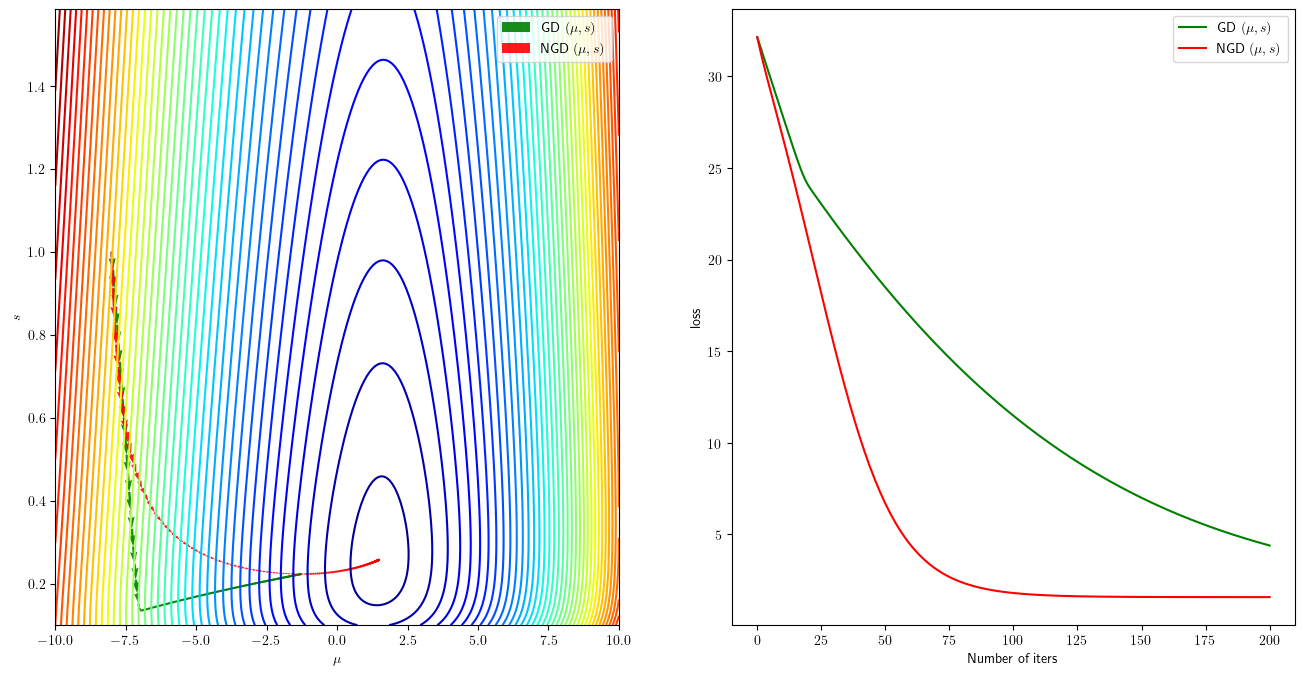

In [14]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1)

ax.contour(mu_list, s_list, Z, 50, cmap="jet")

ax.quiver(
    mu_gd_pre_hist[:-1],
    s_gd_pre_hist[:-1],
    anglesx_gd_pre,
    anglesy_gd_pre,
    label=r"GD $(\mu,s)$",
    scale_units="xy",
    angles="xy",
    scale=1,
    color="g",
    alpha=0.9,
)

ax.quiver(
    mu_ngd_pre_hist[:-1],
    s_ngd_pre_hist[:-1],
    anglesx_ngd_pre,
    anglesy_ngd_pre,
    label=r"NGD $(\mu,s)$",
    scale_units="xy",
    angles="xy",
    scale=1,
    color="r",
    alpha=0.9,
)

ax.set_xlabel(r"$\mu$")
ax.set_ylabel("$s$")
ax.legend(loc="upper right")

ax = fig.add_subplot(1, 2, 2)
ax.plot(
    np.array(list(range(0, max_num_iters + 1))),
    gd_pre_history,
    label=r"GD $(\mu,s)$",
    color="g",
)
ax.plot(
    np.array(list(range(0, max_num_iters + 1))),
    ngd_pre_history,
    label=r"NGD $(\mu,s)$",
    color="r",
)
ax.legend(loc="upper right")
ax.set_xlabel("Number of iters")
ax.set_ylabel("loss")

# plt.tight_layout()
# plt.show()